In [2]:
import pandas as pd
import ccxt
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client


In [3]:
# ========================
# 1. Fetch Binance Data with ccxt
# ========================
exchange = ccxt.binance()

symbol = "BTC/USDT"
timeframe = "1h"
limit = 1000  # number of candles to fetch

ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

df = pd.DataFrame(ohlcv, columns=["timestamp","Open","High","Low","Close","Volume"])
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
df.set_index("timestamp", inplace=True)

In [4]:
# ========================
# 2. Stochastic Oscillator
# ========================
period = 14
smooth_k = 3
smooth_d = 3

lowest_low = df["Low"].rolling(period).min()
highest_high = df["High"].rolling(period).max()

df["%K"] = 100 * (df["Close"] - lowest_low) / (highest_high - lowest_low)
df["%K"] = df["%K"].rolling(smooth_k).mean()
df["%D"] = df["%K"].rolling(smooth_d).mean()


In [6]:
df.dropna(inplace=True)

In [8]:
df.shape

(983, 7)

In [9]:
df.head()

,Open,High,Low,Close,Volume,%K,%D
timestamp,,,,,,,
2025-08-16 09:00:00,117631.09,117703.92,117306.00,117312.00,303.36694,62.765037,64.332203
2025-08-16 10:00:00,117312.00,117447.05,117143.98,117388.00,524.83945,53.560072,60.582719
2025-08-16 11:00:00,117387.99,117540.00,117350.12,117378.52,192.74721,42.059973,52.795027
2025-08-16 12:00:00,117378.52,117747.36,117327.63,117747.36,348.10374,55.077098,50.232381
2025-08-16 13:00:00,117747.35,117799.99,117582.29,117623.52,365.37584,61.862046,52.999706


In [10]:
# ========================
# 3. Swing Highs / Lows
# ========================
lookback_swings = 5

def find_swings(prices, lb):
    labels = [0]*len(prices)
    for i in range(lb, len(prices)-lb):
        if prices[i] == max(prices[i-lb:i+lb+1]):
            labels[i] = -1   # swing high
        elif prices[i] == min(prices[i-lb:i+lb+1]):
            labels[i] = 1    # swing low
    return labels

df["Label"] = find_swings(df["Close"].values, lookback_swings)


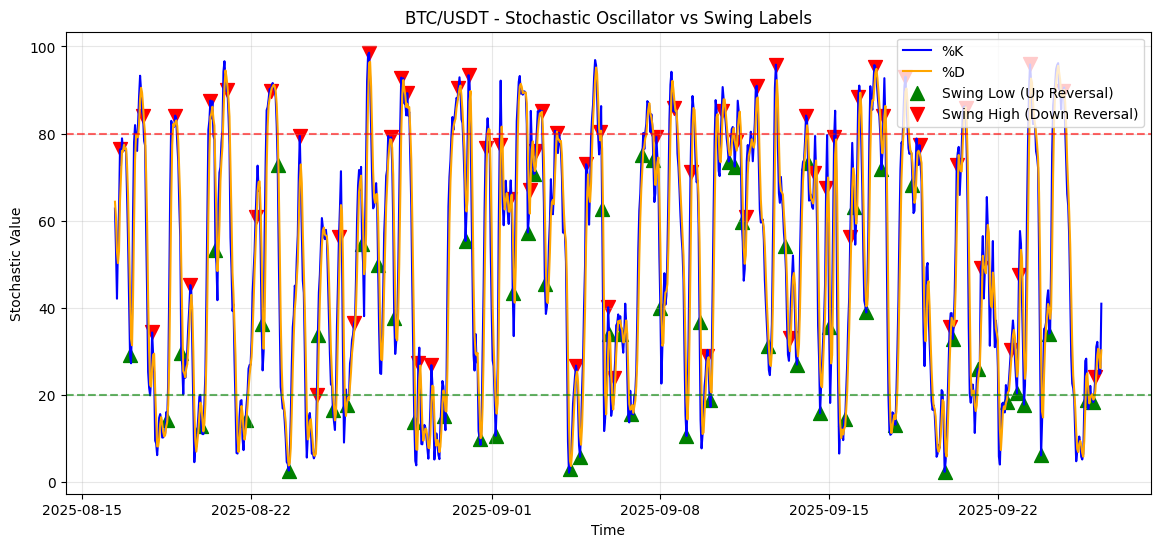

In [12]:
# ========================
# 4. Plot Stochastic with Labels
# ========================
plt.figure(figsize=(14,6))

# Plot stochastic lines
plt.plot(df.index, df["%K"], label="%K", color="blue")
plt.plot(df.index, df["%D"], label="%D", color="orange")

# Overbought / Oversold
plt.axhline(80, color="red", linestyle="--", alpha=0.6)
plt.axhline(20, color="green", linestyle="--", alpha=0.6)

# Plot labels ON STOCHASTIC
plt.scatter(df.index[df["Label"]==1], df["%K"][df["Label"]==1],
            marker="^", color="green", s=100, label="Swing Low (Up Reversal)")
plt.scatter(df.index[df["Label"]==-1], df["%K"][df["Label"]==-1],
            marker="v", color="red", s=100, label="Swing High (Down Reversal)")

plt.title(f"{symbol} - Stochastic Oscillator vs Swing Labels")
plt.xlabel("Time")
plt.ylabel("Stochastic Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()